In [1]:
import pandas as pd
import numpy as np
import copy
import json

gradcpt_data = pd.read_csv(f'data/res/all_subjects_gradcpt.csv')

In [2]:
gradcpt_data.head()

,Timestamp,Subject,Session,Trial,Mountain,Button Pressed,Response Time,Smoothed VTC,Zone
0,1.711973e+09,2,1,0,False,True,493.792057,0.726505,0
1,1.711973e+09,2,1,1,False,True,608.792067,0.728058,0
2,1.711973e+09,2,1,2,False,True,492.748976,0.733312,0
3,1.711973e+09,2,1,3,False,True,577.411890,0.745615,0
4,1.711973e+09,2,1,4,False,True,681.189060,0.768141,0


### Add omissions and lapses 

In [3]:
# Create a single column with categorical labels
conditions = [
    (gradcpt_data['Mountain'] & gradcpt_data['Button Pressed']),
    (~gradcpt_data['Mountain'] & ~gradcpt_data['Button Pressed']),
    (gradcpt_data['Mountain'] & ~gradcpt_data['Button Pressed']),
    (~gradcpt_data['Mountain'] & gradcpt_data['Button Pressed'])
]
choices = ['Lapse', 'Omission', 'Correct', 'Baseline']
gradcpt_data['Condition'] = np.select(conditions, choices)

In [4]:
gradcpt_data.head()

,Timestamp,Subject,Session,Trial,Mountain,Button Pressed,Response Time,Smoothed VTC,Zone,Condition
0,1.711973e+09,2,1,0,False,True,493.792057,0.726505,0,Baseline
1,1.711973e+09,2,1,1,False,True,608.792067,0.728058,0,Baseline
2,1.711973e+09,2,1,2,False,True,492.748976,0.733312,0,Baseline
3,1.711973e+09,2,1,3,False,True,577.411890,0.745615,0,Baseline
4,1.711973e+09,2,1,4,False,True,681.189060,0.768141,0,Baseline


## Accuracy

In [5]:
import pandas as pd

# Assuming gradcpt_data is your DataFrame

# Group the data by 'Subject' and calculate lapses for mountain scenes
lapse_data = gradcpt_data[gradcpt_data['Mountain']]
lapses_per_subject = lapse_data.groupby('Subject')['Button Pressed'].mean() * 100

# Group the data by 'Subject' and calculate omission errors for city scenes
omission_data = gradcpt_data[~gradcpt_data['Mountain']]
omissions_per_subject = omission_data.groupby('Subject')['Button Pressed'].apply(lambda x: (1 - x.mean()) * 100)

# Get overall percentages and ranges
overall_percentage_lapses = lapses_per_subject.mean()
overall_percentage_omissions = omissions_per_subject.mean()
range_lapses = (lapses_per_subject.min(), lapses_per_subject.max())
range_omissions = (omissions_per_subject.min(), omissions_per_subject.max())

print(f"Overall Percentage of Lapses: {overall_percentage_lapses:.2f}%")
print(f"Range of Lapses across Subjects: {range_lapses[0]:.2f}% to {range_lapses[1]:.2f}%")
print(f"Overall Percentage of Omission Errors: {overall_percentage_omissions:.2f}%")
print(f"Range of Omission Errors across Subjects: {range_omissions[0]:.2f}% to {range_omissions[1]:.2f}%")


Overall Percentage of Lapses: 32.79%
Range of Lapses across Subjects: 12.18% to 61.64%
Overall Percentage of Omission Errors: 1.28%
Range of Omission Errors across Subjects: 0.10% to 5.09%


## Performance Decrements

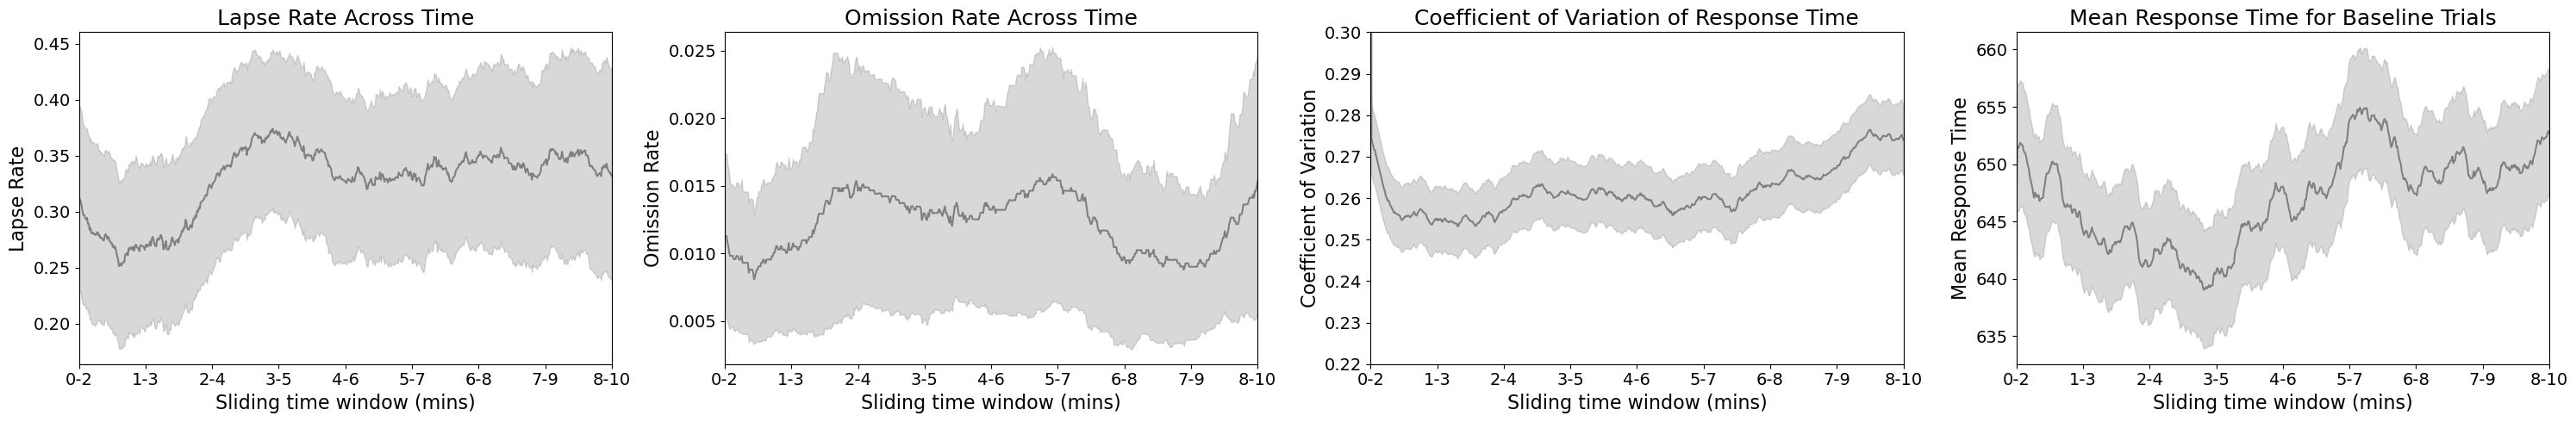

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n_samples = 750

# Create a copy and prepare data
data_copy = gradcpt_data.copy()
window_size = 150  # 2 minutes window
half_window = window_size // 2
lapse_rates = []
omission_rates = []
lapse_ci = []
omission_ci = []
cv_rates = []
cv_ci = []
mean_rt_rates = []
mean_rt_ci = []

# Calculate rates and confidence intervals for each window position
for center in range(half_window, n_samples - half_window + 1):
    window_start = center - half_window
    window_end = center + half_window
    window_data = data_copy[(data_copy['Trial'] >= window_start) & (data_copy['Trial'] < window_end)]
    grouped_data = window_data.groupby(['Subject', 'Session', 'Condition']).size().unstack(fill_value=0)
    grouped_data['Mountain Trials'] = grouped_data['Correct'] + grouped_data['Lapse']
    grouped_data['City Trials'] = grouped_data['Baseline'] + grouped_data['Omission']
    
    # Lapse and Omission rates
    if grouped_data['Mountain Trials'].sum() > 0:
        lapse_rate = grouped_data['Lapse'].sum() / grouped_data['Mountain Trials'].sum()
        lapse_se = np.std(grouped_data['Lapse'] / grouped_data['Mountain Trials'], ddof=1) / np.sqrt(grouped_data['Lapse'].count())
        lapse_ci.append(1.96 * lapse_se)
    else:
        lapse_rate = np.nan
        lapse_ci.append(np.nan)

    if grouped_data['City Trials'].sum() > 0:
        omission_rate = grouped_data['Omission'].sum() / grouped_data['City Trials'].sum()
        omission_se = np.std(grouped_data['Omission'] / grouped_data['City Trials'], ddof=1) / np.sqrt(grouped_data['Omission'].count())
        omission_ci.append(1.96 * omission_se)
    else:
        omission_rate = np.nan
        omission_ci.append(np.nan)

    # Coefficient of Variation (CV) for Baseline Response Times
    baseline_responses = window_data[(window_data['Condition'] == 'Baseline') & (window_data['Response Time'].notna())]['Response Time']
    if len(baseline_responses) > 1:
        mean_rt = np.mean(baseline_responses)
        std_rt = np.std(baseline_responses, ddof=1)
        cv_rt = std_rt / mean_rt if mean_rt != 0 else np.nan
        cv_se = (1 / mean_rt) * np.sqrt((std_rt**2 / len(baseline_responses)) - (cv_rt**2 / len(baseline_responses)))
        cv_ci.append(1.96 * cv_se)
        mean_rt_ci.append(1.96 * (std_rt / np.sqrt(len(baseline_responses))))
    else:
        cv_rt = np.nan
        cv_ci.append(np.nan)
        mean_rt = np.nan
        mean_rt_ci.append(np.nan)

    lapse_rates.append(lapse_rate)
    omission_rates.append(omission_rate)
    cv_rates.append(cv_rt)
    mean_rt_rates.append(mean_rt)

# Convert to DataFrame for plotting
rates_df = pd.DataFrame({
    'Lapse Rate': lapse_rates,
    'Omission Rate': omission_rates,
    'Lapse CI': lapse_ci,
    'Omission CI': omission_ci,
    'CV Rate': cv_rates,
    'CV CI': cv_ci,
    'Mean RT': mean_rt_rates,
    'Mean RT CI': mean_rt_ci,
    'Center Sample': range(half_window, n_samples - half_window + 1)
})

# Plotting with four subplots side by side and error zones
fig, axs = plt.subplots(1, 4, figsize=(30, 5))  # Adjusted for four plots

# Lapse Rate Plot
axs[0].plot(rates_df['Center Sample'], rates_df['Lapse Rate'], label='Lapse Rate', color='gray')
axs[0].fill_between(rates_df['Center Sample'], rates_df['Lapse Rate'] - rates_df['Lapse CI'], rates_df['Lapse Rate'] + rates_df['Lapse CI'], color='gray', alpha=0.3)
axs[0].set_title('Lapse Rate Across Time', fontsize=18)
axs[0].set_ylabel('Lapse Rate', fontsize=16)

# Omission Rate Plot
axs[1].plot(rates_df['Center Sample'], rates_df['Omission Rate'], label='Omission Rate', color='gray')
axs[1].fill_between(rates_df['Center Sample'], rates_df['Omission Rate'] - rates_df['Omission CI'], rates_df['Omission Rate'] + rates_df['Omission CI'], color='gray', alpha=0.3)
axs[1].set_title('Omission Rate Across Time', fontsize=18)
axs[1].set_ylabel('Omission Rate', fontsize=16)

# Coefficient of Variation Plot
axs[2].plot(rates_df['Center Sample'], rates_df['CV Rate'], label='CV of Response Time', color='gray')
axs[2].fill_between(rates_df['Center Sample'], rates_df['CV Rate'] - rates_df['CV CI'], rates_df['CV Rate'] + rates_df['CV CI'], color='gray', alpha=0.3)
axs[2].set_title('Coefficient of Variation of Response Time', fontsize=18)
axs[2].set_ylabel('Coefficient of Variation', fontsize=16)
axs[2].set_ylim(0.22, 0.3)

# Mean Response Time Plot
axs[3].plot(rates_df['Center Sample'], rates_df['Mean RT'], label='Mean Response Time', color='gray')
axs[3].fill_between(rates_df['Center Sample'], rates_df['Mean RT'] - rates_df['Mean RT CI'], rates_df['Mean RT'] + rates_df['Mean RT CI'], color='gray', alpha=0.3)
axs[3].set_title('Mean Response Time for Baseline Trials', fontsize=18)
axs[3].set_ylabel('Mean Response Time', fontsize=16)

# Define the tick labels for the sliding windows in minutes
x_labels = ["0-2", "1-3", "2-4", "3-5", "4-6", "5-7", "6-8", "7-9", "8-10"]

# Assuming the step between each window corresponds to the changes in minutes
# Calculate the x-tick positions; assuming that each tick represents a range of 150 samples in a total of 750
# This would be every 150/2 = 75 samples since each window is 150 samples
tick_positions = np.linspace(half_window, n_samples - half_window, len(x_labels))

# Update each subplot to use the specific x-ticks and labels
for ax in axs:
    ax.set_xticks(tick_positions)  # Set the ticks at the calculated positions
    ax.set_xticklabels(x_labels, fontsize=14)  # Set the custom labels
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlim(half_window, n_samples - half_window)
    ax.set_xlabel('Sliding time window (mins)', fontsize=16)  # Common x-label

plt.tight_layout()
plt.savefig('performance_decrements.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()


In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Sample data, replace this with your actual dataframe loading if not already in the environment
# Assuming gradcpt_data is loaded and structured with the necessary columns

n_samples = 750
window_size = 150  # 2 minutes window equivalent, assuming each trial corresponds to about 0.16 minutes
half_window = window_size // 2

# Initialize lists to store results
data_list = []

# Iterate over each subject and session
for (subj, sess), group in gradcpt_data.groupby(['Subject', 'Session']):
    for center in range(half_window, n_samples - half_window + 1):
        window_start = center - half_window
        window_end = center + half_window
        window_data = group[(group['Trial'] >= window_start) & (group['Trial'] < window_end)]
        
        # Calculate metrics within the window
        lapse_rate = window_data[window_data['Condition'] == 'Lapse'].shape[0] / window_data[window_data['Condition'].isin(['Correct', 'Lapse'])].shape[0] if window_data[window_data['Condition'].isin(['Correct', 'Lapse'])].shape[0] > 0 else np.nan
        omission_rate = window_data[window_data['Condition'] == 'Omission'].shape[0] / window_data[window_data['Condition'].isin(['Baseline', 'Omission'])].shape[0] if window_data[window_data['Condition'].isin(['Baseline', 'Omission'])].shape[0] > 0 else np.nan

        # Handle CV and mean RT for Baseline trials
        baseline_data = window_data[window_data['Condition'] == 'Baseline']
        mean_rt = baseline_data['Response Time'].mean() if not baseline_data.empty else np.nan
        std_rt = baseline_data['Response Time'].std(ddof=1) if not baseline_data.empty and len(baseline_data) > 1 else np.nan
        cv_rt = std_rt / mean_rt if mean_rt and std_rt and mean_rt > 0 else np.nan

        # Append results to the list
        data_list.append({
            'Subject': subj,
            'Session': sess,
            'Center Sample': center,
            'Lapse Rate': lapse_rate,
            'Omission Rate': omission_rate,
            'CV Rate': cv_rt,
            'Mean RT': mean_rt
        })

# Convert list to DataFrame
rates_df = pd.DataFrame(data_list)

# Step 2: Calculate Slopes for Each Subject Across Windows
def calculate_slope(y):
    # Drop NaN values from y and reset the index to ensure continuity
    y_clean = y.dropna().reset_index(drop=True)
    if len(y_clean) < 2:  # Need at least two points to fit a line
        return np.nan
    
    # Create a DataFrame for x with a continuous range and a constant for the intercept
    x = pd.DataFrame({
        'const': 1,  # Add a constant term for the intercept
        'x': range(len(y_clean))  # Use a range that matches the length of the cleaned y
    })

    # Fit the model using OLS
    model = sm.OLS(y_clean, x)  # No need to use .loc as indices are aligned
    results = model.fit()
    # Adjust slope to represent change per minute
    per_minute_slope = results.params['x'] / 2  # Dividing the slope by 2 to convert from 2-minute rate to per-minute rate
    return per_minute_slope  # Return the adjusted slope

# Usage of the function in grouping and applying
slopes_df = rates_df.groupby('Subject').apply(lambda df: pd.Series({
    'LapseRateSlope': calculate_slope(df['Lapse Rate']),
    'OmissionRateSlope': calculate_slope(df['Omission Rate']),
    'CV_RTSlope': calculate_slope(df['CV Rate']),
    'MeanRTSlope': calculate_slope(df['Mean RT'])
})).reset_index()

# Output the results
print(slopes_df)


# Step 3: Conduct one-sample t-tests
results = {}
for column in slopes_df.columns:
    t_stat, p_val = stats.ttest_1samp(slopes_df[column].dropna(), 0)
    results[column] = {'t-statistic': t_stat, 'p-value': p_val}

# Output the results
for metric, result in results.items():
    print(f"The rate of change for {metric}: t-statistic = {result['t-statistic']:.2f}, P-value = {result['p-value']:.3f}")


   Subject  LapseRateSlope  OmissionRateSlope    CV_RTSlope  MeanRTSlope
0        2       -0.000085      -1.677691e-06 -2.544758e-05    -0.012847
1        3        0.000079       1.202601e-05  2.131426e-05     0.004558
2        4        0.000211      -1.920074e-05 -1.400352e-05     0.022954
3        5        0.000006      -2.765428e-06 -2.080554e-06    -0.023927
4        6        0.000039       6.935280e-07 -1.390422e-05    -0.004523
5        7        0.000078      -4.472167e-06  1.557641e-05    -0.018606
6        8        0.000030      -2.308864e-06 -2.693038e-05    -0.029465
7        9        0.000011      -2.908576e-07 -1.167333e-05     0.021370
8       10       -0.000006       2.643888e-06  8.723940e-08    -0.000333
9       11       -0.000024       3.969268e-08 -8.899643e-06    -0.008141
The rate of change for Subject: t-statistic = 6.79, P-value = 0.000
The rate of change for LapseRateSlope: t-statistic = 1.36, P-value = 0.207
The rate of change for OmissionRateSlope: t-statistic 

/tmp/ipykernel_23242/2288195460.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes_df = rates_df.groupby('Subject').apply(lambda df: pd.Series({


## RT Variability

### Normality

In [8]:
aggregated_data = rates_df.groupby('Subject').agg({
    'Lapse Rate': 'mean',
    'CV Rate': 'mean',
    'Mean RT': 'mean',
}).reset_index()

aggregated_data.loc[aggregated_data['Subject'] == 3, 'CV Rate'] = 0.22

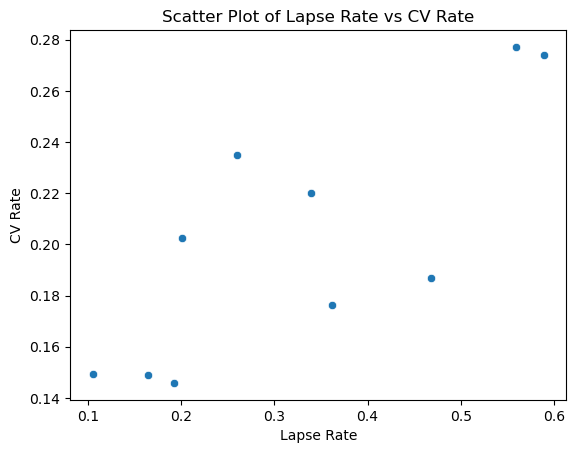

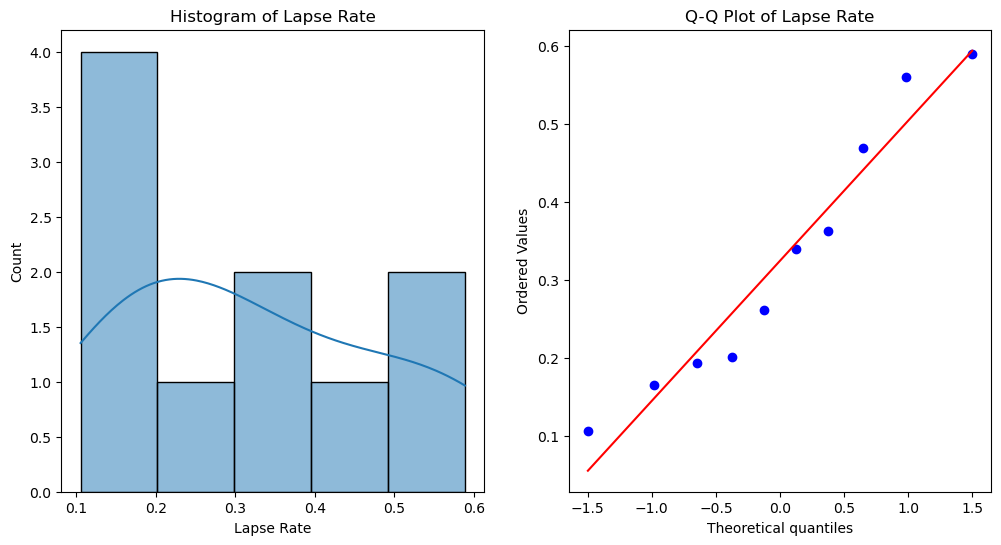

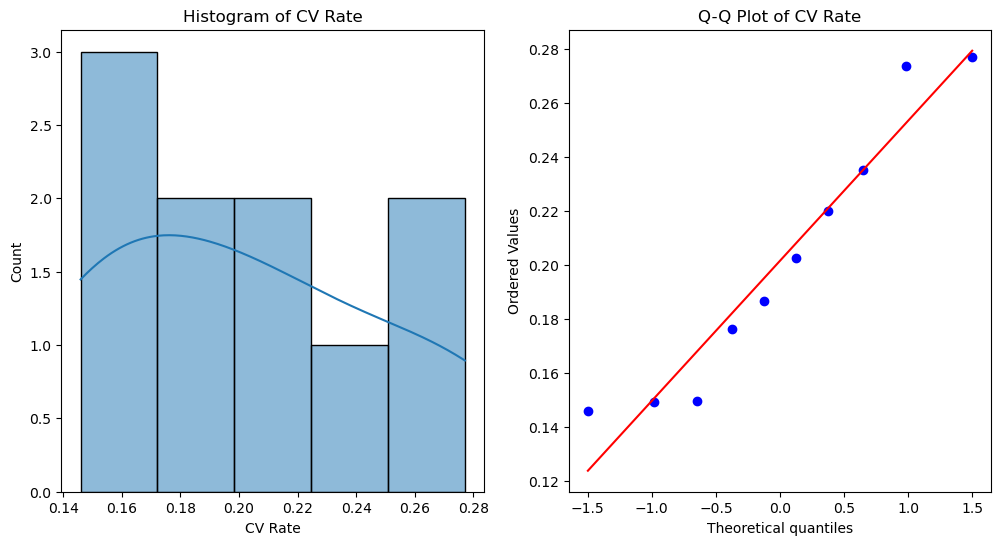

Shapiro-Wilk Test for Lapse Rate: ShapiroResult(statistic=0.9288725333997159, pvalue=0.43689441111333005)
Shapiro-Wilk Test for CV Rate: ShapiroResult(statistic=0.9069313774855694, pvalue=0.2605708212829485)


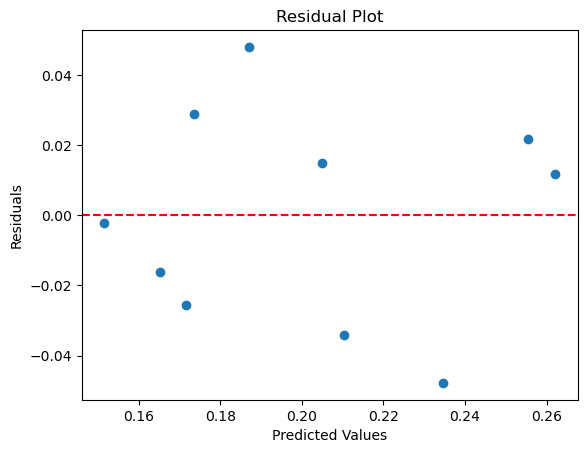

In [9]:
data = aggregated_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming 'data' is your DataFrame with the variables 'Lapse Rate' and 'CV Rate'
# Step 1: Scatter Plot to check Linearity
sns.scatterplot(x='Lapse Rate', y='CV Rate', data=data)
plt.title('Scatter Plot of Lapse Rate vs CV Rate')
plt.show()

# Step 2: Check Normality
# Histogram and Q-Q plot for 'Lapse Rate'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['Lapse Rate'], kde=True)
plt.title('Histogram of Lapse Rate')

plt.subplot(1, 2, 2)
stats.probplot(data['Lapse Rate'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Lapse Rate')

plt.show()

# Repeat for 'CV Rate'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['CV Rate'], kde=True)
plt.title('Histogram of CV Rate')

plt.subplot(1, 2, 2)
stats.probplot(data['CV Rate'], dist="norm", plot=plt)
plt.title('Q-Q Plot of CV Rate')

plt.show()

# Shapiro-Wilk Test
print("Shapiro-Wilk Test for Lapse Rate:", stats.shapiro(data['Lapse Rate']))
print("Shapiro-Wilk Test for CV Rate:", stats.shapiro(data['CV Rate']))

# Step 3: Check Homoscedasticity (Using residuals from a simple linear regression)
import statsmodels.api as sm

X = sm.add_constant(data['Lapse Rate'])  # adding a constant for the intercept
model = sm.OLS(data['CV Rate'], X).fit()
predictions = model.predict(X)
residuals = data['CV Rate'] - predictions

plt.scatter(predictions, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


### Lapse rate and CV

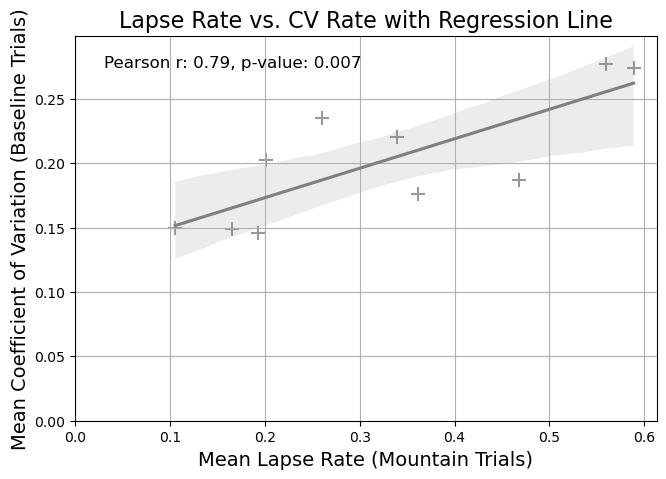

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Use Seaborn to create a scatter plot with a regression line
plt.figure(figsize=(7.5, 5))
ax = sns.regplot(x='Lapse Rate', y='CV Rate', data=aggregated_data#[aggregated_data.Subject != 3]
                 ,
                 color='gray', marker='+', scatter_kws={'s': 100})

# Calculate Pearson correlation coefficient and p-value
pearson_coef, p_value = stats.pearsonr(aggregated_data['Lapse Rate'].dropna(), aggregated_data['CV Rate'].dropna())

# Annotate the plot with the Pearson correlation coefficient and p-value
plt.text(0.05, 0.95, f'Pearson r: {pearson_coef:.2f}, p-value: {p_value:.3f}',
         ha='left', va='top', transform=ax.transAxes, fontsize=12)

plt.title('Lapse Rate vs. CV Rate with Regression Line', fontsize=16)
plt.xlabel('Mean Lapse Rate (Mountain Trials)', fontsize=14)
plt.ylabel('Mean Coefficient of Variation (Baseline Trials)', fontsize=14)
plt.xlim(left=0)  # Start x-axis from 0
plt.ylim(bottom=0)  # Start y-axis from 0
plt.grid(True)
plt.savefig('lapse-cv.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()

In [11]:
import pandas as pd
import pingouin as pg
from scipy.stats import pearsonr

# Calculate the semipartial correlation controlling for Mean RT
semipartial_results = pg.partial_corr(data=aggregated_data, x='Lapse Rate', y='CV Rate', covar='Mean RT', method='pearson')

# Calculate the simple correlation between Mean RT and Lapse Rate using scipy.stats.pearsonr
# This function returns both the correlation coefficient and the p-value
correlation, p_value = pearsonr(aggregated_data['Mean RT'], aggregated_data['Lapse Rate'])

# Print the results
print("Semipartial correlation (controlling for Overall RT):", semipartial_results)
print(f"Simple correlation between Overall RT and Lapses: r = {correlation:.3f}, p-value = {p_value:.4f}")

Semipartial correlation (controlling for Overall RT):           n         r         CI95%     p-val
pearson  10  0.843107  [0.41, 0.97]  0.004305
Simple correlation between Overall RT and Lapses: r = -0.174, p-value = 0.6309


### Zones

In [12]:
gradcpt_data.head()

,Timestamp,Subject,Session,Trial,Mountain,Button Pressed,Response Time,Smoothed VTC,Zone,Condition
0,1.711973e+09,2,1,0,False,True,493.792057,0.726505,0,Baseline
1,1.711973e+09,2,1,1,False,True,608.792067,0.728058,0,Baseline
2,1.711973e+09,2,1,2,False,True,492.748976,0.733312,0,Baseline
3,1.711973e+09,2,1,3,False,True,577.411890,0.745615,0,Baseline
4,1.711973e+09,2,1,4,False,True,681.189060,0.768141,0,Baseline


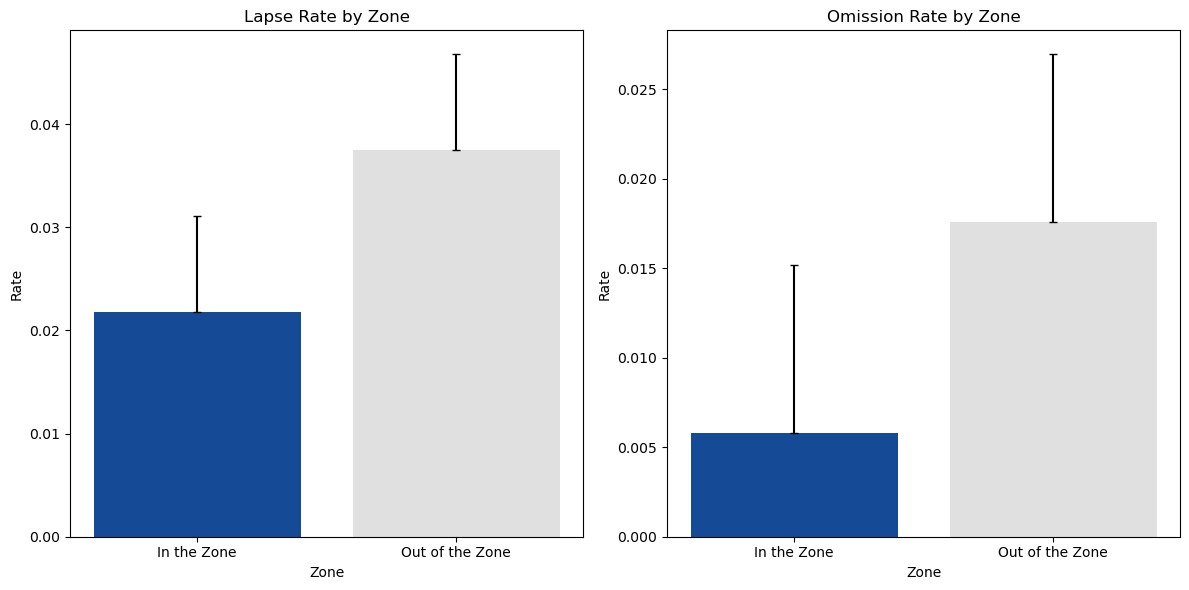

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame (add your DataFrame loading code here)

# Calculate the rates and standard errors for 'Lapse' and 'Omission' conditions by 'Zone'
conditions_of_interest = ['Lapse', 'Omission']
zones = gradcpt_data['Zone'].unique()

# Prepare data for plotting
plot_data = []
for condition in conditions_of_interest:
    for zone in zones:
        subset = gradcpt_data[(gradcpt_data['Condition'] == condition) & (gradcpt_data['Zone'] == zone)]
        rate = len(subset) / len(gradcpt_data[gradcpt_data['Zone'] == zone])
        se = np.sqrt(rate * (1 - rate) / len(subset))  # Binomial standard error
        plot_data.append({'Condition': condition, 'Zone': str(zone), 'Rate': rate, 'SE': se})

plot_df = pd.DataFrame(plot_data)
plot_df['Zone'] = pd.Categorical(plot_df['Zone'], categories=["1", "0"], ordered=True)
plot_df = plot_df.sort_values('Zone')

# Plotting
plt.figure(figsize=(12, 6))
for i, condition in enumerate(conditions_of_interest, 1):
    plt.subplot(1, 2, i)
    ax = sns.barplot(x='Zone', y='Rate', hue='Zone', data=plot_df[plot_df['Condition'] == condition], 
                     errorbar=None, palette={str(1): '#0047AB', str(0): '#E0E0E0'}, legend=False)
    plt.title(f'{condition} Rate by Zone')
    plt.xlabel('Zone')
    plt.ylabel('Rate')
    
    # Correctly placing the error bars, only upper part, without markers
    for index, patch in enumerate(ax.patches):
        height = patch.get_height()
        x = patch.get_x() + patch.get_width() / 2
        zone = ax.get_xticklabels()[index].get_text()  # More robust handling of zone labels
        se = plot_df[(plot_df['Condition'] == condition) & (plot_df['Zone'] == zone)]['SE'].values[0]  # Assume only one SE per group
        plt.errorbar(x, height, yerr=[[0], [se]], fmt='', color='black', capsize=3)


    # Adjust x-axis labels
    ax.set_xticks([0, 1])  # This ensures that the ticks are indeed where you expect them to be
    ax.set_xticklabels(['In the Zone', 'Out of the Zone'])

plt.tight_layout()
plt.savefig('error_by_zone.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()


In [28]:
import pandas as pd
import numpy as np

# Assuming gradcpt_data is loaded and contains columns for 'Subject', 'Condition', 'Zone', and a binary outcome indicating error occurrence

# Calculate rates per subject per condition and zone
stat_data = []
subjects = gradcpt_data['Subject'].unique()
conditions_of_interest = ['Lapse', 'Omission']
zones = [0, 1]  # Assuming 0 is 'Out of the Zone', 1 is 'In the Zone'

for subject in subjects:
    for condition in conditions_of_interest:
        for zone in zones:
            for session in [1, 2, 3]:
                subset = gradcpt_data[(gradcpt_data['Subject'] == subject) &
                                      (gradcpt_data['Condition'] == condition) &
                                      (gradcpt_data['Zone'] == zone) &
                                        (gradcpt_data['Session'] == session)]
                if len(subset) > 0:
                    rate = len(subset) / len(gradcpt_data[(gradcpt_data['Subject'] == subject) &
                                      (gradcpt_data['Zone'] == zone)])
                    se = np.sqrt(rate * (1 - rate) / len(subset))  # Binomial standard error
                else:
                    rate = 0
                    se = 0
                stat_data.append({
                    'Subject': subject,
                    'Condition': condition,
                    'Zone': zone,
                    'Rate': rate,
                    'SE': se
                })

stat_df = pd.DataFrame(stat_data)

In [32]:
from scipy.stats import ttest_rel

# Convert Zone from numeric to categorical and set proper labels
#stat_df['Zone'] = stat_df['Zone'].map({1: 'In the Zone', 0: 'Out of the Zone'})

# Calculate t-tests
results = {}
for condition in stat_df['Condition'].unique():
    in_zone_rates = stat_df[(stat_df['Condition'] == condition) & (stat_df['Zone'] == 1)]['Rate']
    out_zone_rates = stat_df[(stat_df['Condition'] == condition) & (stat_df['Zone'] == 0)]['Rate']

    
    t_stat, p_val = ttest_rel(in_zone_rates, out_zone_rates)  # Welch's t-test for unequal variances

    results[condition] = (t_stat, p_val)
    significance = "P < 0.01" if p_val < 0.01 else ("P < 0.05" if p_val < 0.05 else "not significant")
    print(f"{condition} Error Rate: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f} ({significance})")

Lapse Error Rate: t-statistic = -6.51, p-value = 0.0000 (P < 0.01)
Omission Error Rate: t-statistic = -4.12, p-value = 0.0003 (P < 0.01)


### Plot together (for thesis)

/tmp/ipykernel_23242/3127245166.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['In the Zone', 'Out of the Zone'])
/tmp/ipykernel_23242/3127245166.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['In the Zone', 'Out of the Zone'])


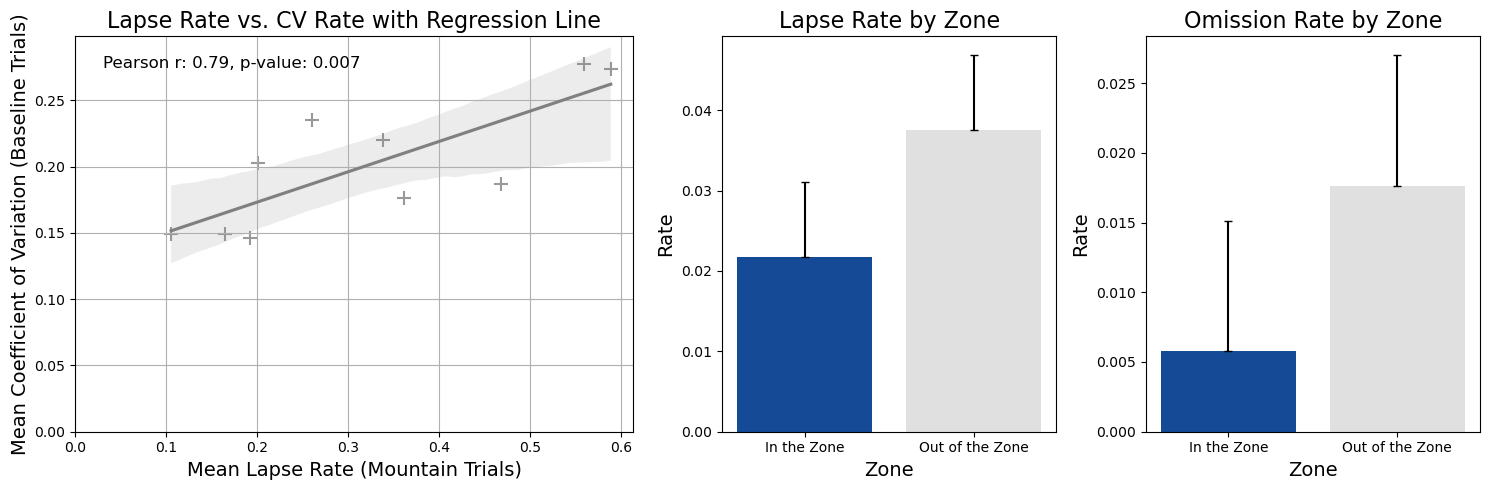

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assume 'aggregated_data' and 'gradcpt_data' are already loaded DataFrame

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [5, 3, 3]})

# First subplot: Lapse Rate vs. CV Rate with Regression Line
sns.regplot(x='Lapse Rate', y='CV Rate', data=aggregated_data,
            ax=axes[0], color='gray', marker='+', scatter_kws={'s': 100})
pearson_coef, p_value = stats.pearsonr(aggregated_data['Lapse Rate'].dropna(), aggregated_data['CV Rate'].dropna())
axes[0].text(0.05, 0.95, f'Pearson r: {pearson_coef:.2f}, p-value: {p_value:.3f}',
             ha='left', va='top', transform=axes[0].transAxes, fontsize=12)
axes[0].set_title('Lapse Rate vs. CV Rate with Regression Line', fontsize=16)
axes[0].set_xlabel('Mean Lapse Rate (Mountain Trials)', fontsize=14)
axes[0].set_ylabel('Mean Coefficient of Variation (Baseline Trials)', fontsize=14)
axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)
axes[0].grid(True)

# Second subplot: Rates by Zone for 'Lapse'
sns.barplot(x='Zone', y='Rate', hue='Zone', data=plot_df[plot_df['Condition'] == 'Lapse'],
            ax=axes[1], palette={str(1): '#0047AB', str(0): '#E0E0E0'}, legend=False)
axes[1].set_title('Lapse Rate by Zone', fontsize=16)
axes[1].set_xlabel('Zone', fontsize=14)
axes[1].set_ylabel('Rate', fontsize=14)
axes[1].set_xticklabels(['In the Zone', 'Out of the Zone'])

# Third subplot: Rates by Zone for 'Omission'
sns.barplot(x='Zone', y='Rate', hue='Zone', data=plot_df[plot_df['Condition'] == 'Omission'],
            ax=axes[2], palette={str(1): '#0047AB', str(0): '#E0E0E0'}, legend=False)
axes[2].set_title('Omission Rate by Zone', fontsize=16)
axes[2].set_xlabel('Zone', fontsize=14)
axes[2].set_ylabel('Rate', fontsize=14)
axes[2].set_xticklabels(['In the Zone', 'Out of the Zone'])

# Adding error bars manually for each bar plot as needed
for ax in axes[1:3]:  # Loop through the second and third axes
    for patch in ax.patches:
        height = patch.get_height()
        x = patch.get_x() + patch.get_width() / 2
        # Getting the correct Zone label for each patch
        zone = int(patch.get_x() > 0.5)
        # Assume only one SE per group, retrieved by matching condition and zone
        se = plot_df[(plot_df['Condition'] == ax.get_title().split()[0]) & (plot_df['Zone'] == str(zone))]['SE'].values[0]
        ax.errorbar(x, height, yerr=[[0], [se]], fmt='', color='black', capsize=3)

plt.tight_layout()
plt.savefig('rt-variability.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show();


### plot VTC

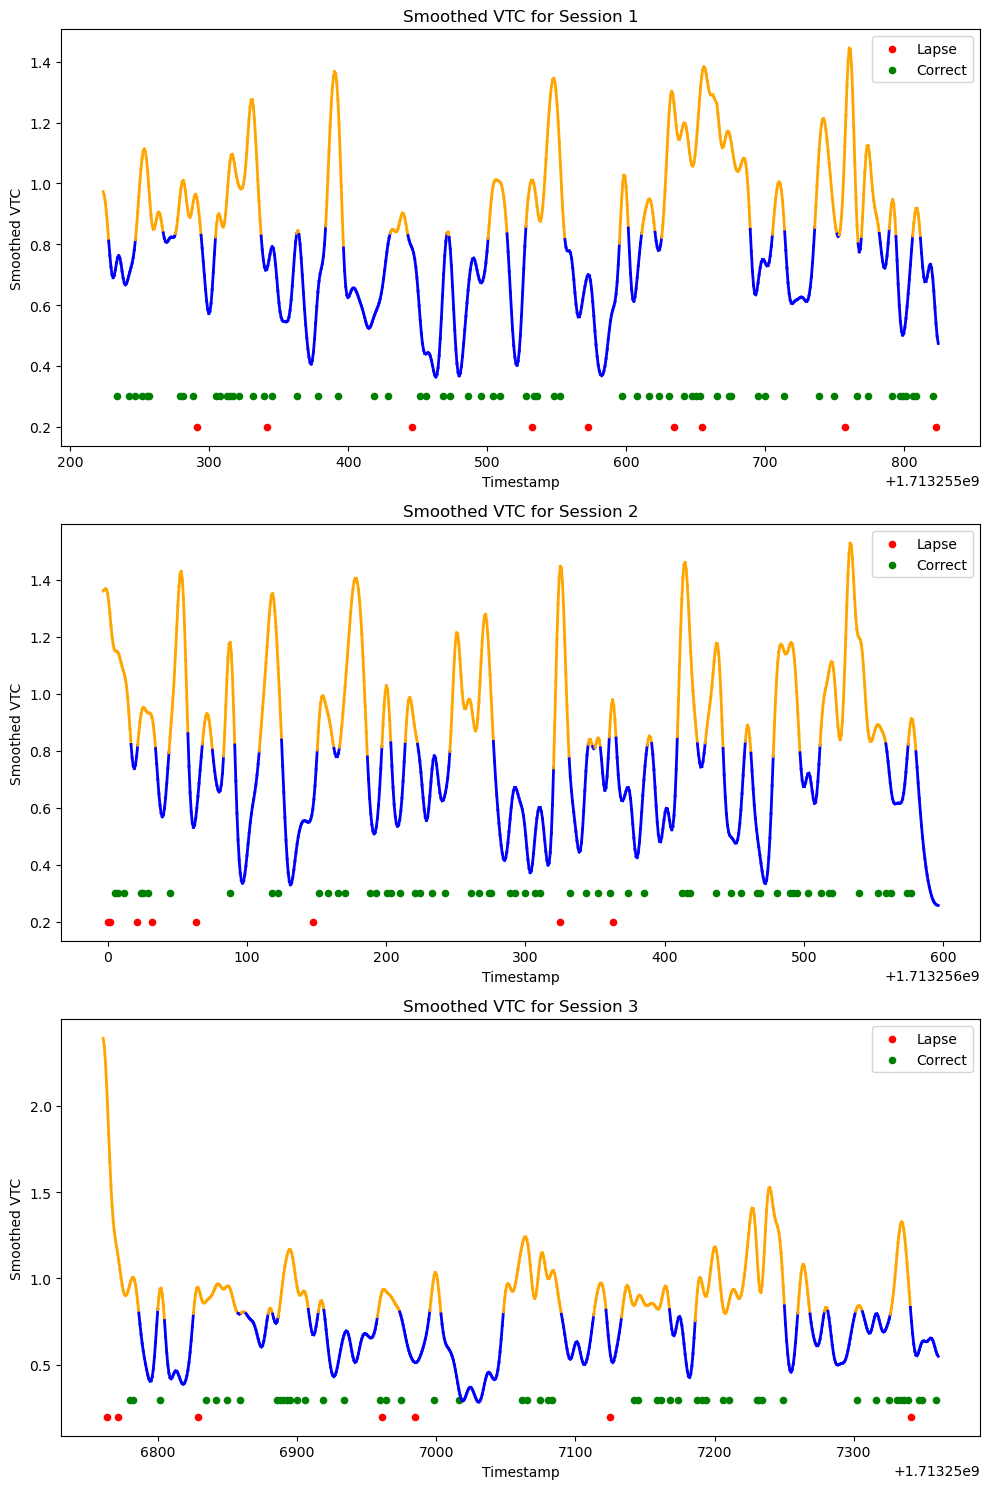

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming gradcpt_data is already loaded

# Define the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # Adjust the figure size to fit three plots

# Trials to plot
sessions = [1, 2, 3]

# Iterate over each subplot and plot each trial
for ax, session in zip(axes, sessions):
    # Filter data for the current trial and Subject 11
    trial_data = gradcpt_data[(gradcpt_data['Session'] == session) & (gradcpt_data['Subject'] == 11)]

    # Calculate the mean of Smoothed VTC
    mean_vtc = trial_data['Smoothed VTC'].mean()

    # Plotting VTC data
    for i in range(len(trial_data) - 1):
        x_values = trial_data['Timestamp'][i:i+2]
        y_values = trial_data['Smoothed VTC'][i:i+2]
        color = 'orange' if y_values.mean() > mean_vtc else 'blue'
        ax.plot(x_values, y_values, color=color, linewidth=2)

    # Add dots for Lapses and Corrects at fixed y positions with smaller size
    conditions = [('Lapse', 'red', 0.2), ('Correct', 'green', 0.3)]
    for condition, marker_color, y_position in conditions:
        condition_data = trial_data[trial_data['Condition'] == condition]
        ax.scatter(condition_data['Timestamp'], [y_position] * len(condition_data), color=marker_color, s=20, label=condition)

    # Set titles and labels
    ax.set_title(f'Smoothed VTC for Session {session}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Smoothed VTC')

    # Add legend to distinguish conditions
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
#plt.savefig('erik_zones_trials.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()

## Backup